<a href="https://colab.research.google.com/github/taegukang35/device_for_blind/blob/main/depthmap_to_pointcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset
> We made Semantic Hallway Dataset downloads available segments.ai or kaggle

*  https://segments.ai/prgmti1/school_hallway/
*  https://segments.ai/prgmti1/school_hallway_ver2/
* integrated ver:  https://www.kaggle.com/taegukang0305/semantic-hallway-dataset


In [3]:
!git clone https://github.com/taegukang35/device_for_blind

Cloning into 'device_for_blind'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 66 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [2]:
import json
import urllib.request
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

This example shows how to get dataset from segments.ai

In [ ]:
base_dir = '/content'
images_dir = os.path.join(base_dir,'images')
os.mkdir(images_dir)


def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype='uint8')
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  return image

#https://segments.ai/prgmti1/school_hallway_v2/releases 에서 받은 v.01 json 파일 
with open('/content/device_for_blind/school_hallway_ver2-v0.1','r') as f:
  dataset = json.load(f) 

for i in range(400):
    img_url = dataset['dataset']['samples'][i]['attributes']['image']['url']
    img_name = dataset['dataset']['samples'][i]['name']
    img = url_to_image(img_url)
    cv2.imwrite(os.path.join(images_dir,img_name),img)

# Depth Estimation

> model results: https://www.youtube.com/watch?v=p8Vm0s8-S_Y&ab_channel=TaeguKang



In [4]:
!pip install tensorflow tensorflow-hub opencv-python matplotlib

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    #tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(gpu,
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
# load model
module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
# https://tfhub.dev/intel/midas/v2/2
def predict_depth(IMG_PATH):
    # input
    img = cv2.imread(IMG_PATH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    img_resized = tf.image.resize(img, [256,256], method='bicubic', preserve_aspect_ratio=False)
    img_resized = tf.transpose(img_resized, [2, 0, 1])
    img_input = img_resized.numpy()
    reshape_img = img_input.reshape(1,3,256,256)
    tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

    output = module.signatures['serving_default'](tensor)
    prediction = output['default'].numpy()
    prediction = prediction.reshape(256, 256)
                
    # output file
    prediction = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    #print(" Write image to: output.png")
    depth_min = prediction.min()
    depth_max = prediction.max()
    # for return depth image
    img_out = (255 * (prediction - depth_min) / (depth_max - depth_min)).astype("uint8")
    
    #cv2.imwrite("output.png", img_out)
    #plt.imshow(img_out,cmap='magma')
    return prediction,img_out
    # plt.show()

(2268, 4032)


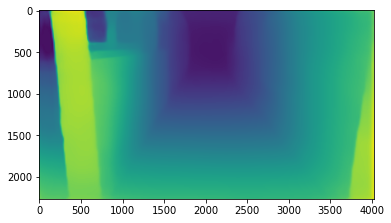

In [7]:
img_path = '/content/20210901_231331.jpg'
depth,img_depth = predict_depth(img_path)
plt.imshow(img_depth)
print(depth.shape)

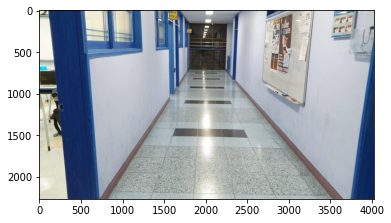

In [8]:
plt.imshow(cv2.imread(img_path))

Definition of Detph of this model? 

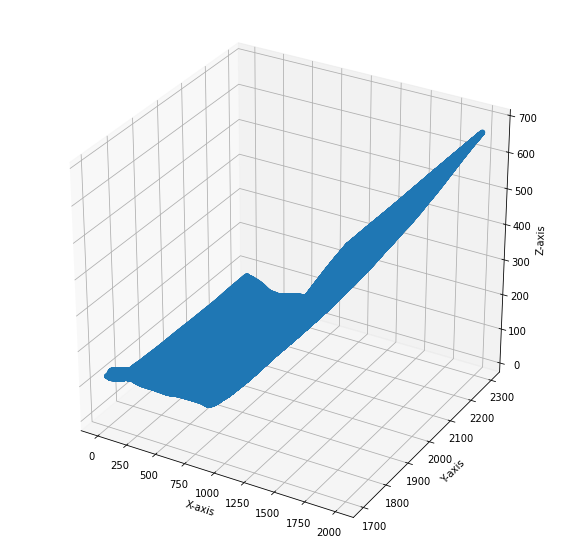

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

X =[i for i in range(2000)]
Y =[i for i in range(1700,2300)]
X,Y = np.meshgrid(X,Y)
Z = depth[X,Y]

ax = plt.axes(projection='3d')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.scatter(X, Y, Z);

In [10]:
print(depth.min(),depth.max())

-55.149014 1208.7804


#Semantic Segmentation




> model results: https://www.youtube.com/watch?v=YziqwVMmjaY&ab_channel=TaeguKang







In [12]:
from keras.models import Model, load_model
seg_model = load_model('/content/device_for_blind/model-best-unet.h5')

In [13]:
def predict_mask(img_path):
    # input
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img_resized = tf.image.resize(img, (256, 256) ,method='bicubic', preserve_aspect_ratio=False)
    img_resized = img_resized.numpy()
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)

    img_input = np.expand_dims(img_resized,axis=0)
    tensor = tf.convert_to_tensor(img_input, dtype=tf.float32)
    mask = seg_model.predict(tensor)

    # Image Thresholding
    threshold = 0.8
    _, mask = cv2.threshold(mask[0][...,0], threshold * mask[0][...,0].max(), 1, cv2.THRESH_BINARY)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    #plt.imshow(mask)
    return mask

##Get depth map of hallway (or Stair)




In [70]:
def get_depth(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    depth,img_depth = predict_depth(img_path)
    mask = predict_mask(img_path)
    hallway_depth = depth*mask

    # erase
    fig = plt.figure(figsize=(15,15))     
    rows = 1
    cols = 3
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(img)
    ax1.set_title('Image')
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(img_depth,cmap='magma')
    ax2.set_title('Depth')
    ax2.axis("off")
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(hallway_depth,cmap='magma')
    ax3.set_title('Extracted Depth')
    ax3.axis("off")
    
    return hallway_depth

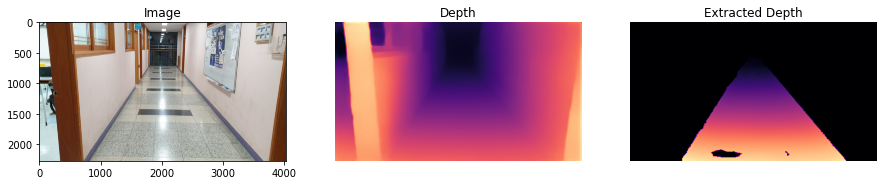

In [71]:
_ = get_depth('/content/20210901_231331.jpg')

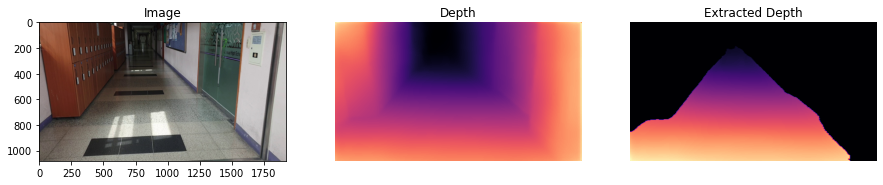

In [66]:
hallway_depth = get_depth('/content/images/54.jpg')

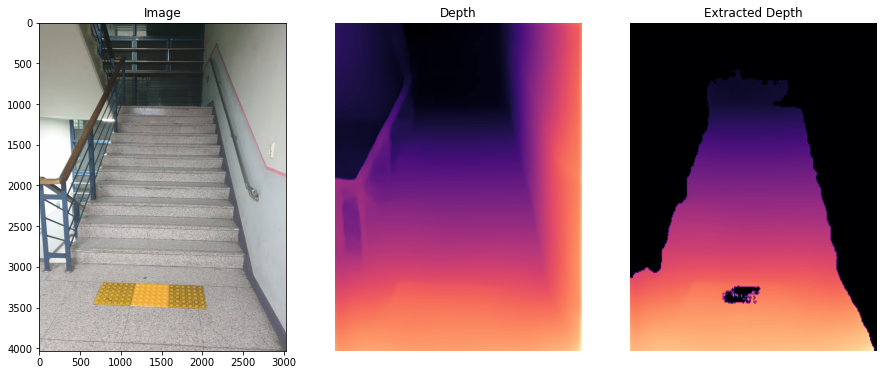

In [67]:
_ = get_depth('/content/20201124_211648.jpg')

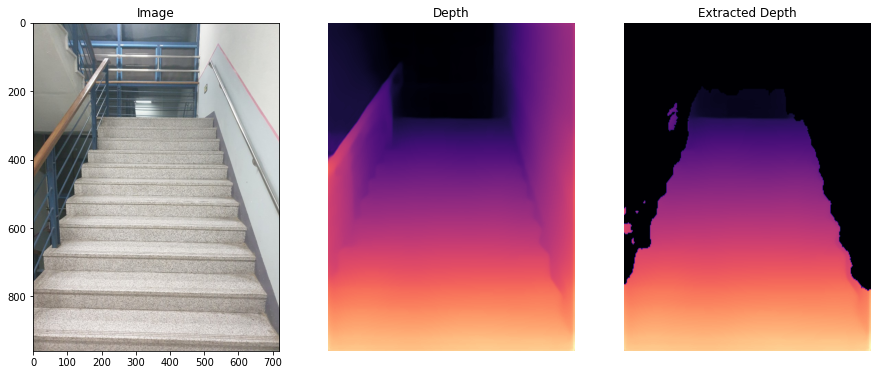

In [68]:
stiat_depth = get_depth('/content/KakaoTalk_20201124_204024796.jpg')

## From depth map to point cloud
: https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f
> (u,v,depth) -> (x,y,z)



In [11]:
class Projection:
    def __init__(self, cx, cy, fx, fy, pxToMetre):
        self.cx = cx
        self.cy = cy
        self.fx = fx
        self.fy = fy
        self.pxToMetre = pxToMetre

    def convert_from_uvd(self, u, v, d):
        #d *= self.pxToMetre
        x_over_z = (self.cx - u) / self.fx
        y_over_z = (self.cy - v) / self.fy
        z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
        x = x_over_z * z
        return x, z

    def run(self, seg: np.ndarray, depth: np.ndarray):
        points = [
            (self.convert_from_uvd(i, j, x), seg[i, j])
            for i, y in enumerate(depth)
            for j, x in enumerate(y)
        ]
        return points

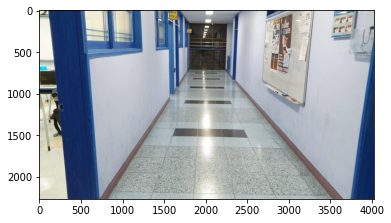

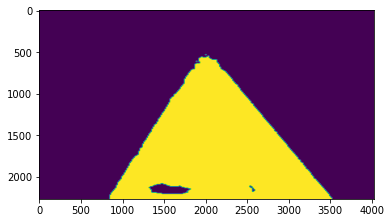

In [18]:
img_path = '/content/20210901_231331.jpg'
img = cv2.imread(img_path)
plt.imshow(img)

depth,_ = predict_depth(img_path)
depth = 1500-depth
mask = predict_mask(img_path)
plt.show()
plt.imshow(mask)

s = Projection(img.shape[1]/2,img.shape[0]/2,2.6,2.6,1)
points = s.run(mask,depth)

In [19]:
points[:10]

[((1240.2684415347715, 1.5995525535666697), 0.0),
 ((1240.5328851950294, 1.599893601938034), 0.0),
 ((1240.79630665847, 1.600233332000011), 0.0),
 ((1241.0585985898067, 1.6005716053241554), 0.0),
 ((1241.3194405964705, 1.6009080087057657), 0.0),
 ((1241.578618521756, 1.6012422659506773), 0.0),
 ((1241.8358115003261, 1.6015739632444683), 0.0),
 ((1242.0910180503474, 1.6019030986760434), 0.0),
 ((1242.3484996365466, 1.6022351681820541), 0.0),
 ((1242.6241403056324, 1.6025906571402004), 0.0)]

In [20]:
points_hallway = [(i[0][0],i[0][1]) for i in points if i[1]==1]

> Density of point cloud by semantic segmentation
--> change density or other algoritm

> sol: get contour of hallway, convex hull? 

> alternative sol: Homography Matrix -> 3x3 matirx: obtained by 10~20 point clouds


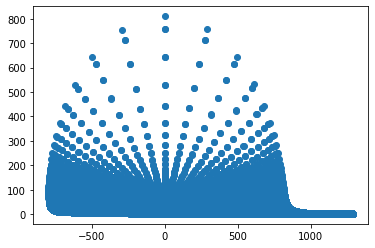

In [21]:
x = [i[0] for i in points_hallway]
z = [i[1] for i in points_hallway]
plt.scatter(x,z)